# FineTuning BERT for Multi-Class Classification with custom datasets

### [Link to Dataset](https://www.kaggle.com/datasets/savasy/ttc4900)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import torch, os
import pandas as pd
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
from torch.utils.data import Dataset

from sklearn.metrics import classification_report

c:\Users\doganeren.ozer\Desktop\twitter scraping\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
!pip install accelerate -U
!pip install transformers==4.30


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 5.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [3]:
df_org= pd.read_csv('/content/drive/MyDrive/MULTI_CLASS_CLASSIFICATION_BERT/df8000veri_son.csv')

df_org = df_org.sample(frac=1.0, random_state=42).reset_index(drop=True)

df_org.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/MULTI_CLASS_CLASSIFICATION_BERT/df8000veri_son.csv'

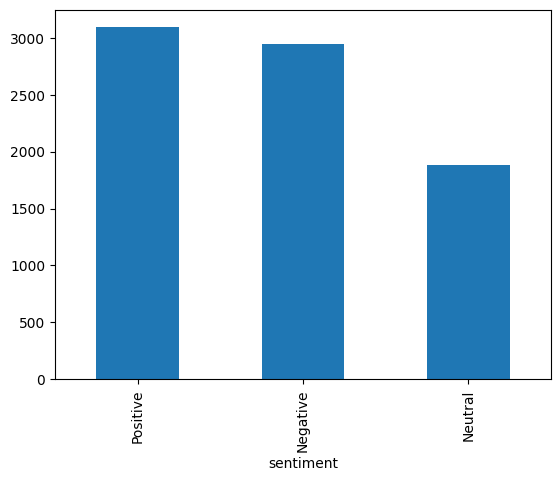

sentiment
Positive    3093
Negative    2945
Neutral     1885
Name: count, dtype: int64


sentiment
Positive    0.390382
Negative    0.371703
Neutral     0.237915
Name: proportion, dtype: float64

In [ ]:
# prompt: sentimentin sayısal dağılımını görsellştirip bastır ayrıca yuzde de ver

import matplotlib.pyplot as plt

df_org['sentiment'].value_counts().plot(kind='bar')
plt.show()

print(df_org['sentiment'].value_counts(normalize=False))
df_org['sentiment'].value_counts(normalize=True)

In [ ]:
labels = df_org['sentiment'].unique().tolist()
labels = [s.strip() for s in labels ]
labels

['Positive', 'Negative', 'Neutral']

In [ ]:
NUM_LABELS= len(labels)

id2label={id:label for id,label in enumerate(labels)}

label2id={label:id for id,label in enumerate(labels)}
label2id

{'Positive': 0, 'Negative': 1, 'Neutral': 2}

In [ ]:
df_org["sentiment"]=df_org.sentiment.map(lambda x: label2id[x.strip()])

In [ ]:
df_org.head()

,clean_text,sentiment
0,şehidimize allah rahmet eylesin mekanı cennet ...,0
1,bak diplomasiz tayyip herkesin cumhurbaşkani m...,1
2,abo staj intibak bağkur kısmi emeklilik için d...,2
3,teşekkürler kılıçdaroğlu,0
4,yasayla ilgili ne düşünüyorsunuz,2


In [ ]:
df_org.shape

(7923, 2)

In [ ]:
# NaN değerlerin temizlenmesi
df_org = df_org.dropna(subset=['clean_text'])

# focal loss denemesi   bunu çalıştır

In [ ]:
'''class CustomBertForSequenceClassification(BertForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        # Modelin orijinal forward çıkışını al
        outputs = super().forward(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        # Eğer label'lar verilmişse, özel loss hesabı yap
        if labels is not None:
            logits = outputs.logits
            # Örneğin Focal Loss kullanmak için
            loss_fct = FocalLoss(alpha=0.25, gamma=2.0)
            loss = loss_fct(logits, labels)
            # Loss değerini çıktıya ekle
            outputs['loss'] = loss

        return outputs if return_dict else (outputs.loss, outputs.logits)'''


"class CustomBertForSequenceClassification(BertForSequenceClassification):\n    def __init__(self, config):\n        super().__init__(config)\n\n    def forward(\n        self,\n        input_ids=None,\n        attention_mask=None,\n        token_type_ids=None,\n        position_ids=None,\n        head_mask=None,\n        inputs_embeds=None,\n        labels=None,\n        output_attentions=None,\n        output_hidden_states=None,\n        return_dict=None,\n    ):\n        # Modelin orijinal forward çıkışını al\n        outputs = super().forward(\n            input_ids,\n            attention_mask=attention_mask,\n            token_type_ids=token_type_ids,\n            position_ids=position_ids,\n            head_mask=head_mask,\n            inputs_embeds=inputs_embeds,\n            output_attentions=output_attentions,\n            output_hidden_states=output_hidden_states,\n            return_dict=return_dict,\n        )\n\n        # Eğer label'lar verilmişse, özel loss hesabı yap\n 

In [ ]:
# model = CustomBertForSequenceClassification.from_pretrained(
#     'dbmdz/bert-base-turkish-uncased',
#     num_labels=NUM_LABELS,
#     id2label=id2label,
#     label2id=label2id
# )
# model.to(device)

## Model Setup

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-uncased", max_length=512)

model_name = "dbmdz/bert-base-turkish-uncased"
# "dbmdz/convbert-base-turkish-mc4-cased"

model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                           num_labels=NUM_LABELS,
                                                           id2label=id2label, label2id=label2id)
model.to("cuda")

Some weights of the model checkpoint at dbmdz/bert-base-turkish-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification wer

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_org, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=42)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((5704, 2), (634, 2), (1585, 2))

In [ ]:
train_encodings = tokenizer(df_train["clean_text"].values.tolist(), truncation=True, padding=True)
val_encodings  = tokenizer(df_val["clean_text"].values.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(df_test["clean_text"].values.tolist(), truncation=True, padding=True)

In [ ]:
class DataLoader(Dataset):
    """
    Custom Dataset class for handling tokenized text data and corresponding labels.
    Inherits from torch.utils.data.Dataset.
    """
    def __init__(self, encodings, labels):
        """
        Initializes the DataLoader class with encodings and labels.

        Args:
            encodings (dict): A dictionary containing tokenized input text data
                              (e.g., 'input_ids', 'token_type_ids', 'attention_mask').
            labels (list): A list of integer labels for the input text data.
        """
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Returns a dictionary containing tokenized data and the corresponding label for a given index.

        Args:
            idx (int): The index of the data item to retrieve.

        Returns:
            item (dict): A dictionary containing the tokenized data and the corresponding label.
        """
        # Retrieve tokenized data for the given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add the label for the given index to the item dictionary
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        """
        Returns the number of data items in the dataset.

        Returns:
            (int): The number of data items in the dataset.
        """
        return len(self.labels)


# optimizer ayarladıgım kısım

In [ ]:
# from transformers import Trainer, TrainingArguments, get_scheduler

# # Optimizer ve scheduler fonksiyonunu tanımlayın
# def get_optimizer_and_scheduler(model):
#     # Optimizer olarak AdamW kullanın
#     optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

#     # Linear scheduler tanımlayın
#     scheduler = get_scheduler(
#         name="linear",  # Scheduler tipi
#         optimizer=optimizer,
#         num_warmup_steps=100,  # Warmup adım sayısı
#         num_training_steps=len(train_dataloader) * training_args.num_train_epochs  # Toplam eğitim adım sayısı
#     )

#     return optimizer, scheduler

## From above DataLoader() The line `item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}`

Here I use a dictionary comprehension that constructs a new dictionary called `item`. This line converts the encoding values associated with the input text at the given index idx into PyTorch tensors.

self.encodings is a dictionary containing tokenized input text with keys like 'input_ids', 'token_type_ids', and 'attention_mask'. These keys represent different aspects of the encoded text that are needed for processing by the BERT model. The values associated with these keys are lists or arrays of integers.

.items() is a method that returns a view object displaying a list of a dictionary's key-value pairs as tuples.

The dictionary comprehension iterates through the key-value pairs of self.encodings with the variables key and val. For each key-value pair, it creates a new key-value pair in the item dictionary, where the key remains the same, and the value is a PyTorch tensor created from the elements at index idx of the original value.

In essence, this line of code is converting the relevant parts of the input encodings (e.g., input IDs, attention masks) at the given index idx into PyTorch tensors and storing them in a new dictionary called item. This format is necessary for input to the BERT model during training or evaluation.

Here's an example of the output format for self.encodings:


```
{
    'input_ids': [
        [101, 2023, 2003, 1037, 2742, 102],
        [101, 1045, 2066, 5009, 2102, 102],
        [101, 2129, 2024, 2017, 1029, 102]
    ],
    'token_type_ids': [
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]
    ],
    'attention_mask': [
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1]
    ]
}
```

In this example, there are three input sentences, each encoded into three different features: input_ids, token_type_ids, and attention_mask.

* input_ids: Lists of token IDs that represent the input text. The integers correspond to the tokens in the tokenizer's vocabulary.

* token_type_ids: Lists of token type IDs that indicate the type of each token. In this case, they are all 0 since there is only one sentence per input. In tasks that require sentence pairs, you would see different token type IDs for different sentences.

* attention_mask: Lists of binary values that indicate whether a given token should be attended to (1) or not (0). In this example, all tokens are attended to, so all the values are 1. Padding tokens would have a value of 0 in the attention_mask.

Note that this example assumes that the maximum sequence length is 6 tokens, and there's no need for padding or truncation. In practice, you would have longer sequences, and padding would be necessary to make all the input sequences have the same length.

In [ ]:
train_dataloader = DataLoader(train_encodings, df_train["sentiment"].values.tolist())
val_dataloader = DataLoader(val_encodings, df_val["sentiment"].values.tolist())
test_dataset = DataLoader(test_encodings, df_test["sentiment"].values.tolist())

## Training with Trainer Class

## compute_metrics

argmax(): The NumPy method argmax() returns the index of the maximum value along a given axis. In a classification problem, we are interested in finding the class with the highest probability for each observation.

(-1): The (-1) inside argmax() represents the axis along which the operation should be performed. In Python, negative indices are used to access elements from the end. So, (-1) here means the last axis, which is the columns in a 2D array.

In [ ]:
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir='./FineTuneModel',
    do_train=True,
    do_eval=True,
    #  The number of epochs, defaults to 3.0
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    # Number of steps used for a linear warmup
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='steps',
   # TensorBoard log directory
    logging_dir='./multi-class-logs',
    logging_steps=250,
    evaluation_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_total_limit=1,
    fp16=True,
    load_best_model_at_end=True
    #metric_for_best_model="eval_loss"
)

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    """
    Computes accuracy, F1, precision, and recall for a given set of predictions.

    Args:
        pred (obj): An object containing label_ids and predictions attributes.
            - label_ids (array-like): A 1D array of true class labels.
            - predictions (array-like): A 2D array where each row represents
              an observation, and each column represents the probability of
              that observation belonging to a certain class.

    Returns:
        dict: A dictionary containing the following metrics:
            - Accuracy (float): The proportion of correctly classified instances.
            - F1 (float): The macro F1 score, which is the harmonic mean of precision
              and recall. Macro averaging calculates the metric independently for
              each class and then takes the average.
            - Precision (float): The macro precision, which is the number of true
              positives divided by the sum of true positives and false positives.
            - Recall (float): The macro recall, which is the number of true positives
              divided by the sum of true positives and false negatives.
    """
    # Extract true labels from the input object
    labels = pred.label_ids

    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)

    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }


# compute metrics, confusion matrix & classification report

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def calculate_confusion_matrix(predictions, true_labels):
    """ Hesaplanan tahminlere göre confusion matrix döndürür. """
    preds = np.argmax(predictions, axis=1)
    return confusion_matrix(true_labels, preds)

def calculate_classification_report(predictions, true_labels):
    """ Hesaplanan tahminlere göre classification report döndürür. """
    preds = np.argmax(predictions, axis=1)
    return classification_report(true_labels, preds, output_dict=True, target_names=[id2label[i] for i in sorted(id2label)])


def plot_confusion_matrix(cm, classes):
    """ Confusion matrix'i görselleştirir. """
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

def plot_classification_report(cr, title='Classification Report'):
    """ Classification report'ı bir heatmap olarak görselleştirir. """
    sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True, cmap='Blues')
    plt.title(title)
    plt.show()

def calculate_classification_report_df(predictions, true_labels):
    """ Hesaplanan tahminlere göre classification report'u DataFrame olarak döndürür. """
    preds = np.argmax(predictions, axis=1)
    report = classification_report(true_labels, preds, target_names=[id2label[i] for i in sorted(id2label)], output_dict=True)
    # Raporu bir DataFrame'e dönüştür
    report_df = pd.DataFrame(report).transpose()
    return report_df

# ağırlık verdiği kısım

In [ ]:
'''import torch
import torch.nn as nn
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

# Sınıf ağırlıklarını tanımlayın (daha önce hesaplanmış olabilir)
class_weights = torch.tensor([0.537, 1.406, 2.344], device=device)

# CrossEntropyLoss fonksiyonunu sınıf ağırlıkları ile başlatın
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# Özel bir Trainer sınıfı tanımlayın, loss hesaplaması için
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss = loss_fn(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss



training_args = TrainingArguments(
    output_dir='./FineTuneModel',
    do_train=True,
    do_eval=True,
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='steps',
    logging_dir='./multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    fp16=True,
    load_best_model_at_end=True
)


# Trainer nesnesini başlatın
trainer = CustomTrainer(
    model=model,  # Önceden yüklenmiş ve ayarlanmış modelinizi kullanın
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=val_dataloader,
    compute_metrics=compute_metrics  # Metrik hesaplama fonksiyonunuz
)


'''

'import torch\nimport torch.nn as nn\nfrom transformers import BertForSequenceClassification, Trainer, TrainingArguments\n\n# Sınıf ağırlıklarını tanımlayın (daha önce hesaplanmış olabilir)\nclass_weights = torch.tensor([0.537, 1.406, 2.344], device=device)\n\n# CrossEntropyLoss fonksiyonunu sınıf ağırlıkları ile başlatın\nloss_fn = nn.CrossEntropyLoss(weight=class_weights)\n\n# Özel bir Trainer sınıfı tanımlayın, loss hesaplaması için\nclass CustomTrainer(Trainer):\n    def compute_loss(self, model, inputs, return_outputs=False):\n        labels = inputs.pop("labels")\n        outputs = model(**inputs)\n        logits = outputs.logits\n        loss = loss_fn(logits.view(-1, self.model.config.num_labels), labels.view(-1))\n        return (loss, outputs) if return_outputs else loss\n\n\n\ntraining_args = TrainingArguments(\n    output_dir=\'./FineTuneModel\',\n    do_train=True,\n    do_eval=True,\n    num_train_epochs=5,\n    per_device_train_batch_size=16,\n    per_device_eval_batch_s

In [ ]:
df_train["sentiment"].value_counts(normalize=True)

sentiment
0    0.389727
1    0.373597
2    0.236676
Name: proportion, dtype: float64

# Ağırlıkların 12 000 veriye göre yeniden düzenlendiği kod

In [ ]:
'''import torch
import torch.nn as nn
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

# Yeni sınıf yüzdelerine dayalı ağırlıkların hesaplanması
percentages = {'Positive': 0.160208, 'Neutral': 0.186227, 'Negative': 0.653565}
total = 100  # Toplam yüzde
num_classes = len(percentages)  # Sınıf sayısı

# Her sınıf için hesaplanan ağırlıklar
class_weights = torch.tensor([1 - percentages[label]) for label in ['Positive', 'Neutral', 'Negative']], device=device)

# CrossEntropyLoss fonksiyonunu yeni sınıf ağırlıkları ile başlatın
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# Özel bir Trainer sınıfı tanımlayın, loss hesaplaması için
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss = loss_fn(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# Eğitim argümanlarını tanımlayın
training_args = TrainingArguments(
    output_dir='./FineTuneModel',
    do_train=True,
    do_eval=True,
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='steps',
    logging_dir='./multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    fp16=True,
    load_best_model_at_end=True
)



# Trainer nesnesini başlatın
trainer = CustomTrainer(
    model=model,  # Önceden yüklenmiş ve ayarlanmış modelinizi kullanın
    args=training_args,
    train_dataset=train_dataloader,  # Eğitim veri setinizi tanımlayın
    eval_dataset=val_dataloader,  # Değerlendirme veri setinizi tanımlayın
    compute_metrics=compute_metrics  # Metrik hesaplama fonksiyonunuz
)
'''

'import torch\nimport torch.nn as nn\nfrom transformers import BertForSequenceClassification, Trainer, TrainingArguments\n\n# Yeni sınıf yüzdelerine dayalı ağırlıkların hesaplanması\npercentages = {\'Positive\': 0.160208, \'Neutral\': 0.186227, \'Negative\': 0.653565}\ntotal = 100  # Toplam yüzde\nnum_classes = len(percentages)  # Sınıf sayısı\n\n# Her sınıf için hesaplanan ağırlıklar\nclass_weights = torch.tensor([1 - percentages[label]) for label in [\'Positive\', \'Neutral\', \'Negative\']], device=device)\n\n# CrossEntropyLoss fonksiyonunu yeni sınıf ağırlıkları ile başlatın\nloss_fn = nn.CrossEntropyLoss(weight=class_weights)\n\n# Özel bir Trainer sınıfı tanımlayın, loss hesaplaması için\nclass CustomTrainer(Trainer):\n    def compute_loss(self, model, inputs, return_outputs=False):\n        labels = inputs.pop("labels")\n        outputs = model(**inputs)\n        logits = outputs.logits\n        loss = loss_fn(logits.view(-1, self.model.config.num_labels), labels.view(-1))\n     

# Normal kodun devamı

In [ ]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned
    model=model,
     # training arguments that we defined above
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=val_dataloader,
    compute_metrics= compute_metrics
)

# OPTİMİZER FONKSIYONUN KULLANILDIĞI KOD

In [ ]:
# Trainer sınıfını optimizer ve scheduler ile başlatın
'''trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=val_dataloader,
    compute_metrics=compute_metrics,
    optimizers=get_optimizer_and_scheduler(model)  # Bu fonksiyon optimizer ve scheduler'ı döndürür
)
'''

"trainer = Trainer(\n    model=model,\n    args=training_args,\n    train_dataset=train_dataloader,\n    eval_dataset=val_dataloader,\n    compute_metrics=compute_metrics,\n    optimizers=get_optimizer_and_scheduler(model)  # Bu fonksiyon optimizer ve scheduler'ı döndürür\n)\n"

In [ ]:
trainer.train(resume_from_checkpoint=False)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,No log,0.498936,0.802839,0.796613,0.800175,0.809076
200,No log,0.525367,0.807571,0.796902,0.815901,0.791426
300,0.549800,0.408903,0.835962,0.825614,0.829576,0.825659
400,0.549800,0.470668,0.854890,0.843407,0.844536,0.844914
500,0.218700,0.431762,0.859621,0.849998,0.849580,0.852081


TrainOutput(global_step=537, training_loss=0.3655070654728781, metrics={'train_runtime': 93.0775, 'train_samples_per_second': 183.847, 'train_steps_per_second': 5.769, 'total_flos': 721086988166496.0, 'train_loss': 0.3655070654728781, 'epoch': 3.0})

In [ ]:
q=[trainer.evaluate(eval_dataset=df_org) for df_org in [train_dataloader, val_dataloader, test_dataset]]

pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.071463,0.981241,0.979662,0.978320,0.981117
val,0.431762,0.859621,0.849998,0.849580,0.852081
test,0.430225,0.866246,0.857200,0.855219,0.860074


In [ ]:
# Model değerlendirmesi
eval_results = trainer.evaluate(eval_dataset=test_dataset)
predictions = trainer.predict(test_dataset).predictions
true_labels = [item['labels'].item() for item in test_dataset]  # Doğru şekilde etiketleri elde etme

In [ ]:
# Confusion Matrix ve Classification Report hesaplamaları
conf_matrix = calculate_confusion_matrix(predictions, true_labels)
class_report = calculate_classification_report(predictions, true_labels)

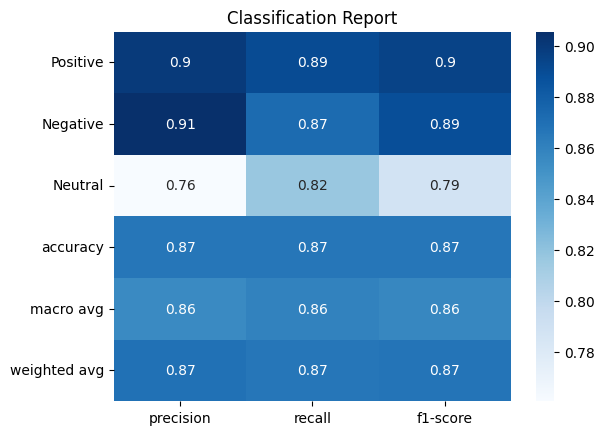

In [ ]:
plot_classification_report(class_report)

In [ ]:
# Modelin predict metodu ile test dataset üzerinden tahminler alınır
predictions_output = trainer.predict(test_dataset)

# Logits (olasılıklar) alınıp, en yüksek olasılığa sahip indeksler seçilir (sınıf tahminleri olarak)
predicted_labels = np.argmax(predictions_output.predictions, axis=-1)

# Test dataset'inden gerçek etiketler çıkarılır
true_labels = [item['labels'].item() for item in test_dataset]

# Gerçek etiketler ve tahminler kullanılarak classification report hesaplanır
report = classification_report(true_labels, predicted_labels, target_names=[id2label[i] for i in sorted(id2label.keys())])

# Classification report yazdırılır
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

    Positive       0.90      0.89      0.90       604
    Negative       0.91      0.87      0.89       604
     Neutral       0.76      0.82      0.79       377

    accuracy                           0.87      1585
   macro avg       0.86      0.86      0.86      1585
weighted avg       0.87      0.87      0.87      1585



In [ ]:
cls=[]
for id,label in id2label.items():
  print(label)
  cls.append(label)


Positive
Negative
Neutral


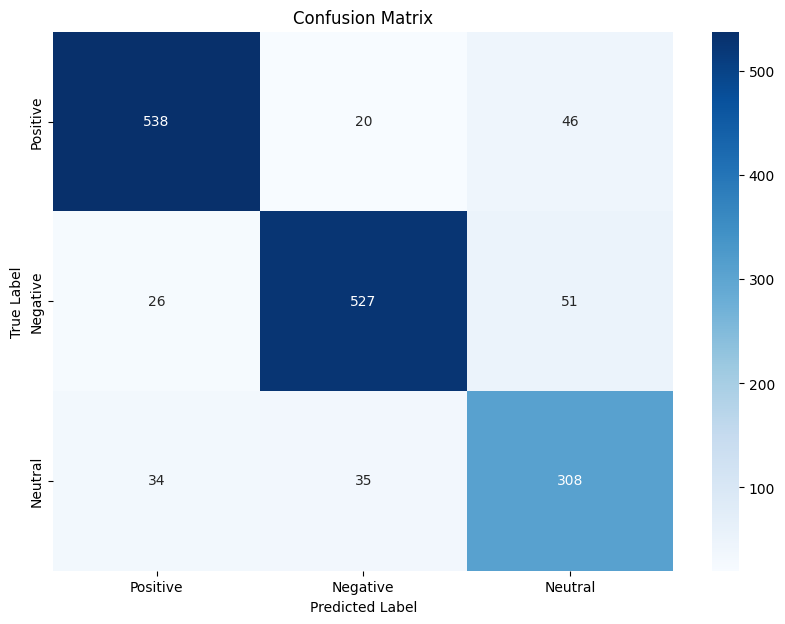

In [ ]:
# Confusion matrix hesaplama
cm = confusion_matrix(true_labels, predicted_labels)

# Görselleştirme
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=cls, yticklabels=cls)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [ ]:
def predict(text):
    """
    Predicts the class label for a given input text

    Args:
        text (str): The input text for which the class label needs to be predicted.

    Returns:
        probs (torch.Tensor): Class probabilities for the input text.
        pred_label_idx (torch.Tensor): The index of the predicted class label.
        pred_label (str): The predicted class label.
    """
    # Tokenize the input text and move tensors to the GPU if available
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")

    # Get model output (logits)
    outputs = model(**inputs)

    probs = outputs[0].softmax(1)
    """ Explanation outputs: The BERT model returns a tuple containing the output logits (and possibly other elements depending on the model configuration). In this case, the output logits are the first element in the tuple, which is why we access it using outputs[0].
eval_loss
    outputs[0]: This is a tensor containing the raw output logits for each class. The shape of the tensor is (batch_size, num_classes) where batch_size is the number of input samples (in this case, 1, as we are predicting for a single input text) and num_classes is the number of target classes.

    softmax(1): The softmax function is applied along dimension 1 (the class dimension) to convert the raw logits into class probabilities. Softmax normalizes the logits so that they sum to 1, making them interpretable as probabilities. """

    # Get the index of the class with the highest probability
    # argmax() finds the index of the maximum value in the tensor along a specified dimension.
    # By default, if no dimension is specified, it returns the index of the maximum value in the flattened tensor.
    pred_label_idx = probs.argmax()
    # Now map the predicted class index to the actual class label
    # Since pred_label_idx is a tensor containing a single value (the predeval_lossicted class index),
    # the .item() method is used to extract the value as a scalar
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label


In [ ]:
# Test with a an example text in Turkish
text = "Makine öğrenimi kendisi de daha da otomatik hale doğru ilerliyor."
# "Machine Learning itself is moving towards more and more automated"
predict(text)

(tensor([[0.4235, 0.0571, 0.5194]], device='cuda:0', grad_fn=<SoftmaxBackward0>),
 tensor(2, device='cuda:0'),
 'Neutral')

## Save model for inference

In [ ]:
model_path = "/content/drive/MyDrive/MULTI_CLASS_CLASSIFICATION_BERT/bert-base-turkish-uncased_8000_veri"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('/content/drive/MyDrive/MULTI_CLASS_CLASSIFICATION_BERT/bert-base-turkish-uncased_8000_veri/tokenizer_config.json',
 '/content/drive/MyDrive/MULTI_CLASS_CLASSIFICATION_BERT/bert-base-turkish-uncased_8000_veri/special_tokens_map.json',
 '/content/drive/MyDrive/MULTI_CLASS_CLASSIFICATION_BERT/bert-base-turkish-uncased_8000_veri/vocab.txt',
 '/content/drive/MyDrive/MULTI_CLASS_CLASSIFICATION_BERT/bert-base-turkish-uncased_8000_veri/added_tokens.json',
 '/content/drive/MyDrive/MULTI_CLASS_CLASSIFICATION_BERT/bert-base-turkish-uncased_8000_veri/tokenizer.json')

## Re-Load saved model for inference

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer= AutoTokenizer.from_pretrained(model_path)
nlp= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


# Modeli load edip test etme

In [ ]:
model.to('cpu')
nlp("Bugün hava çok güzel")
# Today the weather is very nice, I want to go for a walk outside

# Gives below output
#[{'label': 'saglik', 'score': 0.8295329213142395}]
# "Saglik" is a Turkish word that means "health" in English.

[{'label': 'Positive', 'score': 0.974517285823822}]

In [ ]:
nlp("ne kadar berbat")
# Deep Learning and AI is going to change the world

# gives below output
#[{'label': 'teknoloji', 'score': 0.9932782053947449}]

[{'label': 'Negative', 'score': 0.9946911931037903}]

In [ ]:
nlp("bizlere dikkatli olmamızı söylediler")
# Due to recent volatility in the economy, the stock market index has been at quite low levels

#gives below output
#[{'label': 'ekonomi', 'score': 0.9850727915763855}]

[{'label': 'Neutral', 'score': 0.9870932698249817}]

# dbmdz/electra-base-turkish-mc4-uncased-discriminator

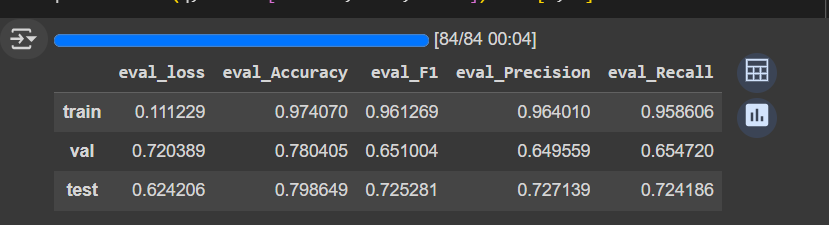

# dbmdz/electra-base-turkish-cased-discriminator

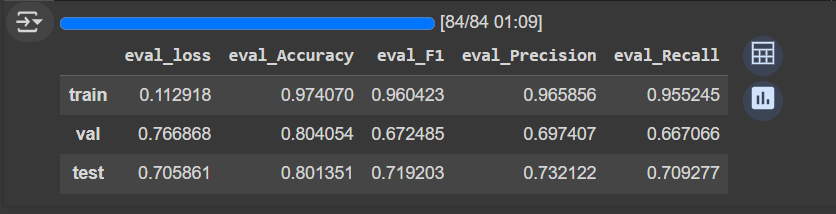

# dbmdz/convbert-base-turkish-mc4-uncased

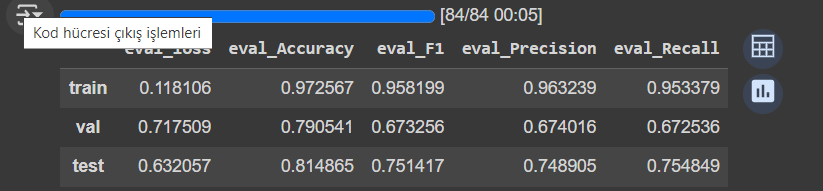

# dbmdz/bert-base-turkish-128k-uncased



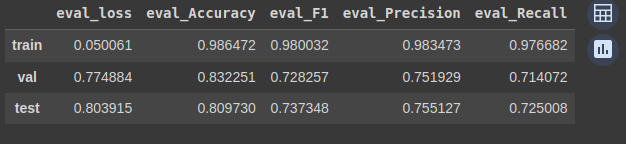

# dbmdz/convbert-base-turkish-mc4-cased



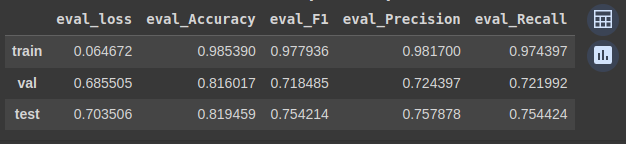# New Section

# dbmdz/distilbert-base-turkish-cased


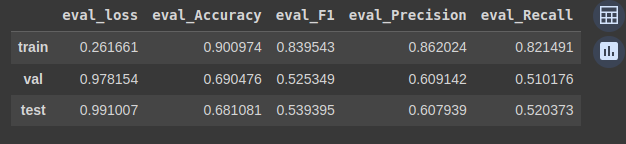

# dbmdz/electra-base-turkish-mc4-cased-discriminator

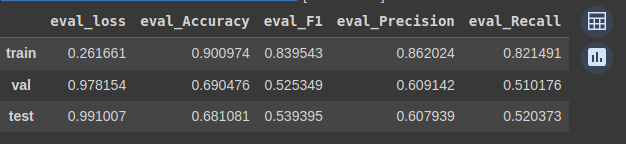

# dbmdz/bert-base-turkish-uncased

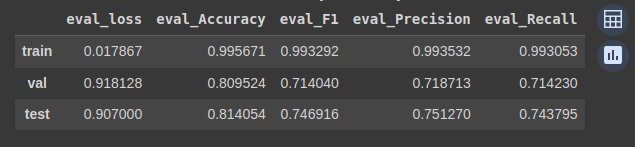

# dbmdz/bert-base-turkish-uncased

**noktalama işaretleri yok**

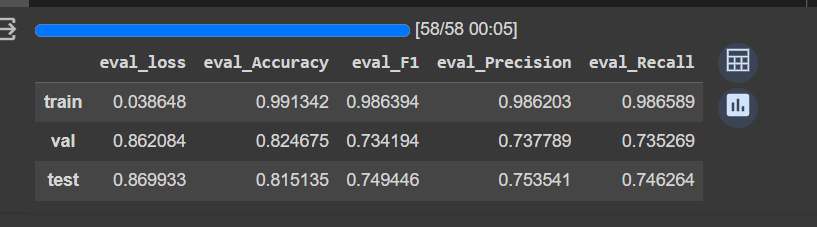

# dbmdz/bert-base-turkish-uncased

**weigth verdim**

{0: 'Negative', 1: 'Positive', 2: 'Neutral'}  

-------- 0.537  --------  1.406         ------   2.344

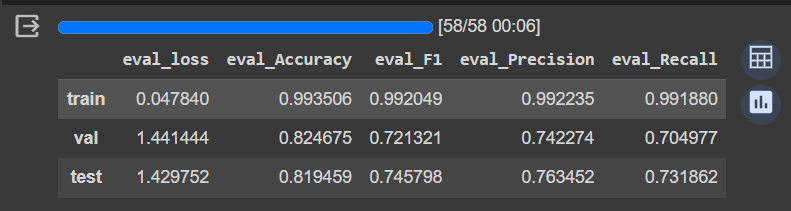

# dbmdz/bert-base-turkish-uncased

**weigth verdim**

{0: 'Negative', 1: 'Positive', 2: 'Neutral'}

-------- 0.500 -------- 2.000 ------ 4.00

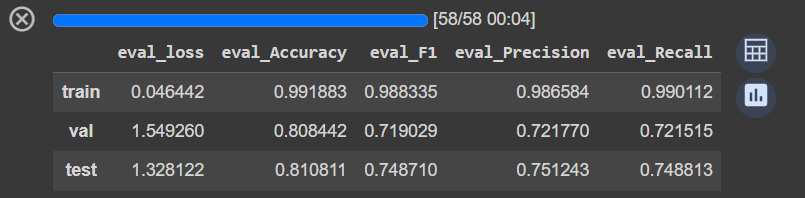

# dbmdz/bert-base-turkish-uncased  weightsiz 4700

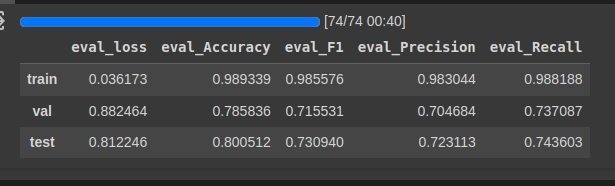

# dbmdz/bert-base-turkish-uncased weightli 4700

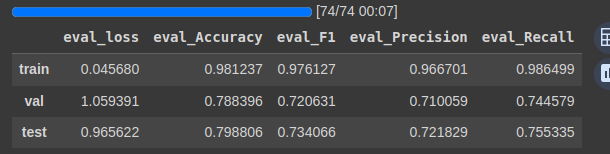

# dbmdz/bert-base-turkish-uncased  

  128 lik olana 12 000 veri etiketlettim

sonra bunu base e verdim ve tahmin etmesini istedim f1 değerinin artıığını accuarcynin değismedini gözlemledim.

veri sayisi arttığı için azınlık olanları daha iyi tahmin etmiş diye yorumladım

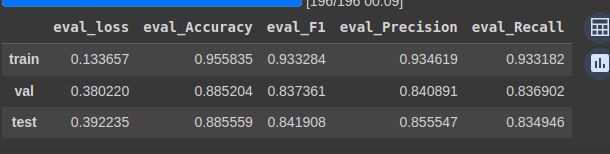

# dbmdz/bert-base-turkish-uncased  

128 lik olana 12 000 veri etiketlettim





**BU BİR ÜSTTEKİNİN WEİGHT VERİLMİŞ HALİ**

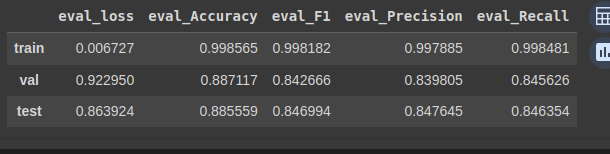

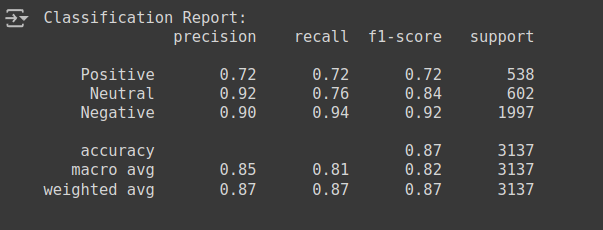

# dbmdz/bert-base-turkish-uncased   ADAM OPTİMİZER KULLANDIM SONUC: KULLANMADIGIM DAHA KÖTÜ SONUÇ VERDİ

**128 lik olana 12 000 veri etiketlettim**

sonra bunu base e verdim ve tahmin etmesini istedim f1 değerinin artıığını accuarcynin değismedini gözlemledim.



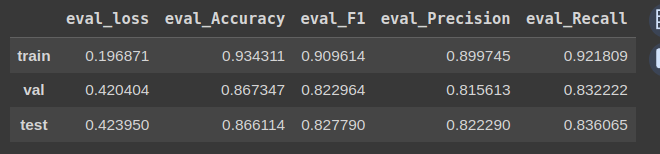

# dbmdz/convbert-base-turkish-mc4-cased ile eğitildi  base uncaed ile de etiketlendi toplam 55 bin veri  

colab gpu bittiği için bağlantım kesildi f1 88 ac 91

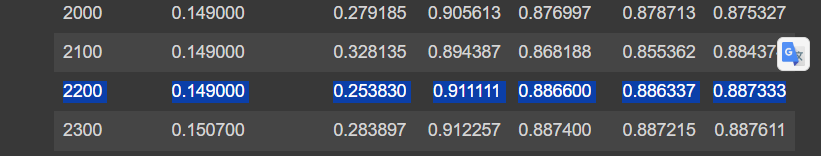

# MODELE VERİ ETİKETLETME

In [ ]:
import pandas as pd
from transformers import pipeline

# CSV dosyasını yükle
new_data = pd.read_csv('/content/drive/MyDrive/MULTI_CLASS_CLASSIFICATION_BERT/birlestirilmis45_11_temizlenmis.csv')

In [ ]:
new_data.shape

(54558, 13)

In [ ]:
# Veriyi temizle (örneğin, NaN değerlerini kaldır)
new_data = new_data.dropna(subset=['clean_text'])

In [ ]:
new_data.shape

(54558, 13)

In [ ]:
new_data.head()

,created_at,id_str,text,clean_text,quote_count,reply_count,retweet_count,favorite_count,lang,user_id_str,conversation_id_str,username,tweet_url
0,Mon Nov 26 20:14:41 +0000 2018,1.067150e+18,"""@kilicdarogluk Hadi istifa et de soğandan değ...",hadi istifa et de soğandan değil sevinçten yaş...,0.0,0.0,0.0,0.0,tr,4.277020e+08,1.067088e+18,sefayurtbasi,https://twitter.com/sefayurtbasi/status/106714...
1,Wed Jan 01 09:27:32 +0000 2020,1.212304e+18,"""@herkesicinCHP bay kemal nurettın sozenı ıbb ...",bay kemal nurettın sozenı ıbb nın ımamın danış...,0.0,0.0,0.0,0.0,tr,1.208087e+18,1.210533e+18,hakkturk1,https://twitter.com/hakkturk1/status/121230433...
2,Thu May 12 15:04:29 +0000 2016,7.307757e+17,"""@Akparti @akpgiresun @tirebolubaskan imana g...",imana gelin la millet susuzluktan cenabet gezi...,0.0,0.0,0.0,0.0,tr,3.226207e+09,7.307757e+17,Dev_giresun,https://twitter.com/Dev_giresun/status/7307756...
3,Sun Apr 22 17:04:54 +0000 2018,9.881013e+17,"""@iyiparti @Akparti Kafaları hertürlü............",kafaları hertürlü çalışır,0.0,0.0,0.0,0.0,tr,6.255937e+08,9.880543e+17,kamalolu,https://twitter.com/kamalolu/status/9881013478...
4,Mon Jul 20 17:27:49 +0000 2020,1.285265e+18,"""@kilicdarogluk Başımız sağ olsun şehitlerimiz...",başımız sağ olsun şehitlerimizin toprağı bol r...,0.0,0.0,0.0,0.0,tr,1.268465e+18,1.285257e+18,askitomuyumbenn,https://twitter.com/askitomuyumbenn/status/128...


(54556, 13)

In [ ]:
# Tokenizer ve modeli yükle
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-uncased")

In [ ]:
model_path = "/content/drive/MyDrive/MULTI_CLASS_CLASSIFICATION_BERT/bert-base-turkish-uncased_noktalama_yok"
model = AutoModelForSequenceClassification.from_pretrained(model_path,
                                                           num_labels=NUM_LABELS,
                                                           id2label=id2label, label2id=label2id)

In [ ]:
# Veriyi tokenleştir
encodings = tokenizer(list(new_data.clean_text), truncation=True, padding=True, return_tensors="pt")

In [ ]:
# Modeli değerlendirme moduna al
model.eval()

# Cihaza göre ayarla
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
import torch

# GPU belleğini temizle
torch.cuda.empty_cache()


batch_size = 8
predictions = []

for i in range(0, len(encodings['input_ids']), batch_size):
    input_ids = encodings['input_ids'][i:i+batch_size].to(device)
    attention_mask = encodings['attention_mask'][i:i+batch_size].to(device)
    with torch.no_grad():
        batch_predictions = model(input_ids, attention_mask=attention_mask)
        predictions.append(batch_predictions)

In [ ]:
# predictions listesindeki her bir SequenceClassifierOutput'dan logits'ı al
logits_list = [output.logits for output in predictions]

# logits'ları birleştir
combined_predictions = torch.cat(logits_list, dim=0)

In [ ]:
import torch.nn.functional as F

# Softmax uygula: logits'den olasılıklar elde et
probabilities = F.softmax(combined_predictions, dim=1)

# En yüksek olasılığa sahip sınıfın indeksini al (yani tahmini etiket)
predicted_labels = torch.argmax(probabilities, dim=1)

# Tahmin edilen sınıf isimlerini elde et
predicted_class_names = [model.config.id2label[label.item()] for label in predicted_labels]

In [ ]:
# DataFrame oluştur
df_predictions = pd.DataFrame({
    'clean_text': new_data['clean_text'].reset_index(drop=True),  # Index'i resetlemek önemli, çünkü dropna'dan sonra farklılık olabilir
    'sentiment': predicted_class_names
})

In [ ]:
# DataFrame'i gözlemleyelim
df_predictions.tail(10)

,clean_text,sentiment
54548,sizin çözüm dediginiz o çocukları gun uzaklaşt...,Negative
54549,evimdeyim sizden yardım istiyorm yıl önce geld...,Negative
54550,tk sabah saat dan beri rötar rötar süresi üzer...,Negative
54551,bakanımızsn sokağa çikma yasaği genelgelerinde...,Neutral
54552,sınava hayır,Negative
54553,seçimi kazanınca yunanistan a kaçan ülkesini a...,Negative
54554,bu işlerden başka gündeminiz ne olaki,Negative
54555,şu yorumları bir okuyun sayfa sahibine utanaca...,Negative
54556,gavurlar ile aynı çuvala girmeyinki dolar yüks...,Negative
54557,çocukluğumuzdan bir güzel anı daha sonsuzluğa ...,Positive


In [ ]:
# DataFrame'i CSV dosyası olarak kaydedelim
csv_file_path = '/content/drive/MyDrive/MULTI_CLASS_CLASSIFICATION_BERT/55,000_veri_turkish-uncased_ile_etiketlendi.csv'
df_predictions.to_csv(csv_file_path, index=False)

# 8000 veri

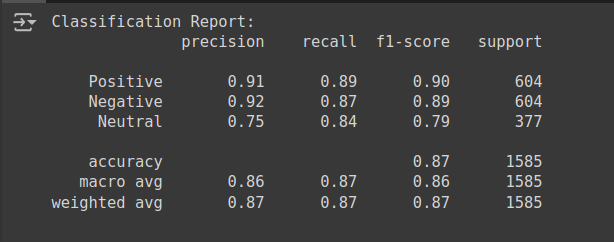

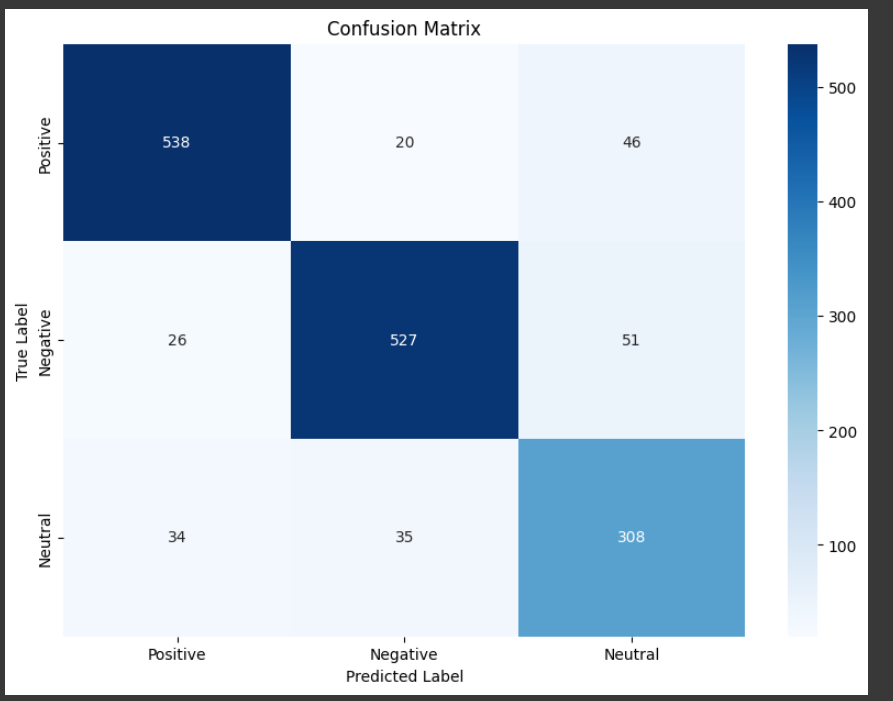